In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from io import StringIO
from IPython.display import Image  
import pydotplus

from sklearn.model_selection import cross_validate, cross_val_score

In [3]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [4]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0) # * data['result_prop']

In [5]:
mask = data[['allies_infantry', 'axis_infantry']].isnull().any(1)

In [6]:
data=data[~mask]

In [7]:
cols_to_fill = ['allies_planes', 'axis_planes', 'axis_tanks', 'allies_tanks', 'axis_guns', 'allies_guns']
mask_null = data[cols_to_fill].isnull()
data[cols_to_fill] = data[cols_to_fill].fillna(0)

In [8]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month
data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [9]:
cols = [
    'allies_infantry', 'axis_infantry', 'allies_tanks', 'axis_tanks', 
    'allies_planes', 'axis_planes', 'duration'
]

## Models

In [10]:
model1 = DecisionTreeClassifier(random_state=2019, max_depth=10)

In [11]:
data[cols].head(10)

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_planes,axis_planes,duration
0,240.0,3400.0,0.0,0.0,0.0,60.0,1
4,50000.0,5000.0,58.0,498.0,0.0,0.0,1
6,720.0,42200.0,0.0,350.0,0.0,0.0,1
8,2800.0,38000.0,0.0,0.0,0.0,0.0,1
9,225000.0,425000.0,0.0,500.0,0.0,0.0,1
10,124000.0,175000.0,0.0,0.0,0.0,0.0,1
11,8800.0,175000.0,0.0,200.0,0.0,0.0,1
12,70000.0,45000.0,400.0,800.0,0.0,0.0,1
13,22500.0,20000.0,0.0,0.0,0.0,0.0,1
14,18000.0,30000.0,0.0,400.0,0.0,0.0,1


In [12]:
import warnings

warnings.filterwarnings('ignore')

In [13]:
cv = cross_validate(model1,
                    data[cols], 
                    data['result_num'],
                    cv=4)

cv = pd.DataFrame(cv)
print(cv.to_string())

   fit_time  score_time  test_score  train_score
0  0.006166    0.003837    0.500000      1.00000
1  0.004712    0.002329    0.571429      1.00000
2  0.005641    0.004074    0.428571      1.00000
3  0.005737    0.001906    0.250000      0.96875


In [14]:
cv['test_score'].mean()

0.4375

# Feature Engineering

#### Army size comparison

In [15]:
data['infantry_ratio'] = data['allies_infantry'] / data['axis_infantry']
cols.append('infantry_ratio')

for tp in 'infantry', 'planes', 'tanks', 'guns':
    data[f'{tp}_diff'] = data[f'allies_{tp}'] - data[f'axis_{tp}']
    cols.append(f'{tp}_diff')

In [16]:
scores = cross_val_score(model1, 
                         data[cols], 
                         data['result_num'],
                         cv=4)
pd.np.mean(scores)

0.5141774891774892

In [17]:
scores

array([0.40909091, 0.52380952, 0.52380952, 0.6       ])

# leaders

In [18]:
model1.__str__().replace('\n                       ', ' ')

"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,\n            splitter='best')"

In [19]:
from collections import Counter
# lea

In [20]:
alead = data['axis_leaders'].str.split(',')

In [21]:
def _generate_binary_most_common(col, N=10):
    mask = col.notnull()
    lead_list = [ el.strip() for _, cell in col[mask].iteritems() for el in cell if el != '']
    c = Counter(lead_list)
    
    mc = c.most_common(N)
    df = pd.DataFrame(index=col.index, columns=[name[0] for name in mc])
    
    for name in df.columns:
        df.loc[mask, name] = col[mask].apply(lambda x: name in x).astype(int)
    return df.fillna(0)
    
    
    

In [22]:
axis_pop = _generate_binary_most_common(data['axis_leaders'].str.split(','), N=2)
allies_pop = _generate_binary_most_common(data['allies_leaders'].str.split(','), N=2)

In [23]:
data2 = pd.concat([data, axis_pop, allies_pop], axis=1)

In [24]:
cols2 = cols + axis_pop.columns.tolist() + allies_pop.columns.tolist()

In [25]:
model2 = DecisionTreeClassifier(random_state=2019, max_depth=15)

In [26]:
scores = cross_val_score(model1, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.5369047619047619

### Belligerents

In [27]:
data2['belligerents.allies']

0                                                 Poland
4                                                 Poland
6                                                 Poland
8                                                 Poland
9                                                 Poland
10                                       Polish Republic
11                                                Poland
12                                                Poland
13                                                Poland
14                                                Poland
15                                          Soviet Union
17                                          Soviet Union
18                                          Soviet Union
19                                               Finland
20                                               Finland
21                                               Finland
22                                               Finland
23                             

In [28]:
scores = cross_val_score(model1, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.5369047619047619

## Hyper-parameter optimisation

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [30]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(5, 20),
              "max_features": sp_randint(1, len(cols2)),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]}

In [31]:
rs = RandomizedSearchCV(
    model1,
    param_distributions=param_dist,
    cv=4, iid=False,
    random_state=2019,
    n_iter=50
)

In [32]:
rs.fit(data2[cols2], data2['result_num'])

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,
            splitter='best'),
          fit_params=None, iid=False, n_iter=50, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11bec6080>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11bec6278>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11bec6be0>, 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=2019, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [33]:
rs.best_score_

0.5613636363636363

In [34]:
rs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=2019, splitter='best')

# Visualize the graph

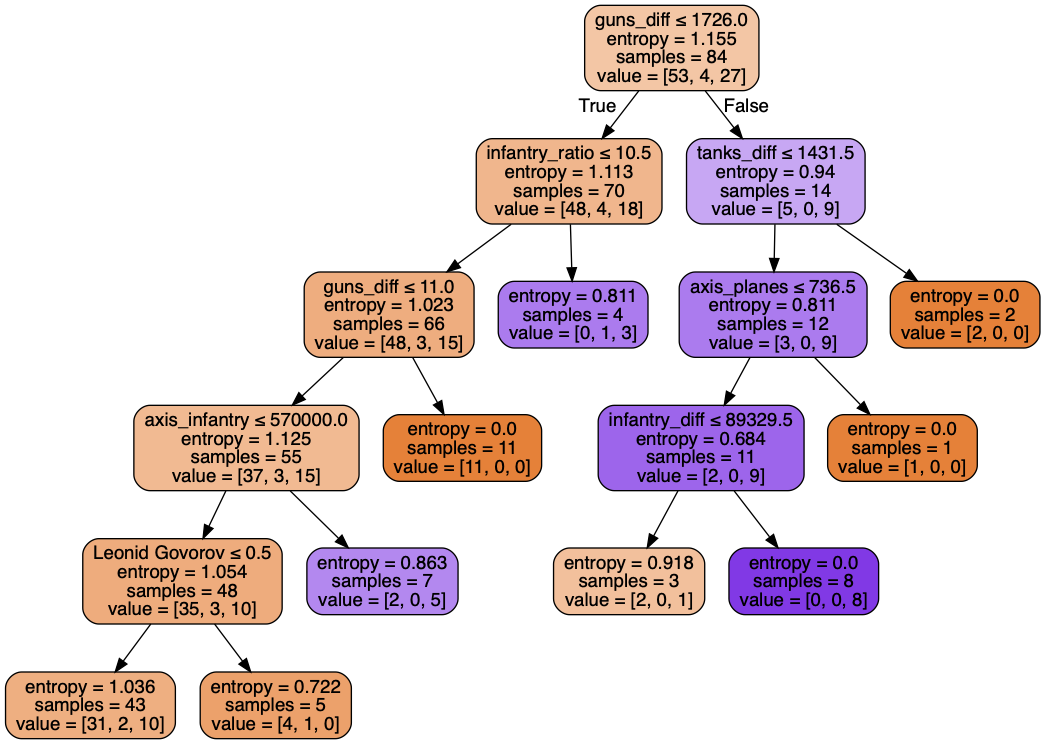

In [35]:
dot_data = StringIO()

export_graphviz(rs.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=cols2)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Storing tree chart to a file

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(random_state=2019)

In [38]:
scores = cross_val_score(rf, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.5357683982683983

In [39]:
param_dist2 = {
              'n_estimators': sp_randint(50, 2000),
              "max_depth": sp_randint(5, 25),
              "max_features": sp_randint(1, len(cols2)),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]
}

In [40]:
rs2 = RandomizedSearchCV(
    rf,
    param_distributions=param_dist2,
    cv=4, iid=False,
    random_state=2019,
    n_iter=50
)